# OLS

This notebook will help you code up simple simulations to gain intuition about omitted variable bias.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pathlib
import matplotlib.pyplot as plt

## Set up directory structure

In [2]:
repo_f = pathlib.Path.cwd().parent

## Simple OVB

In this section we will:  
1. Write a function that creates data where Y is a function of X_1 and X_2 (which are correlated)  
2. Run bi-variate OLS with Y and X_1 and inspect how biased our estimate of corr(X_1, Y) is.

In [3]:
def create_OVB_data(coef_interest=0.8, corr_X_1_X_2=0.5, corr_X_2_epsilon=0.5):

    # Create a dataframe 

    # Main independent variable
    df = pd.DataFrame(np.random.normal(10, 5, 100000).reshape(100000, 1), columns=['X_1'])

    # Error term
    df['epsilon_1'] = np.random.normal(0, 5, 100000) 
    df['epsilon_2'] = np.random.normal(0, 5, 100000) 

    # Omitted variable that is correlated with the error term and the main independent variable
    df['X_2'] = corr_X_1_X_2*df['X_1'] + df['epsilon_2']

    # Dependent variable
    df['Y'] = coef_interest*df['X_1'] + corr_X_2_epsilon*df['X_2'] + 5 + df['epsilon_1'] 

    return df


In [4]:
# Run OLS regression over grid of values of the correlation between X_2 and epsilon
# as well as correlation between X_2 and X_1 and save the coefficient in a dataframe
   
# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['corr_X_1_X_2', 'corr_X_2_epsilon', 'coef'])
corr_X_2_epsilon_grid = np.arange(-1, 1.1, 0.1)
corr_X_1_X_2_grid = np.arange(-1, 1.1, 0.1)


for corr_X_1_X_2 in corr_X_1_X_2_grid:
    for corr_X_2_epsilon in corr_X_2_epsilon_grid:

        df = create_OVB_data(corr_X_1_X_2=corr_X_1_X_2, corr_X_2_epsilon=corr_X_2_epsilon)

        # Run OLS regression
        X = df[['X_1']]
        X = sm.add_constant(X)
        Y = df['Y']
        model = sm.OLS(Y, X)
        results = model.fit()

        tmp = pd.DataFrame({'corr_X_1_X_2': corr_X_1_X_2, 'corr_X_2_epsilon': corr_X_2_epsilon, 'coef': results.params['X_1']}, index=[0])
        # Save the coefficient of interest
        df_results = pd.concat([df_results, tmp])
                                                            
    



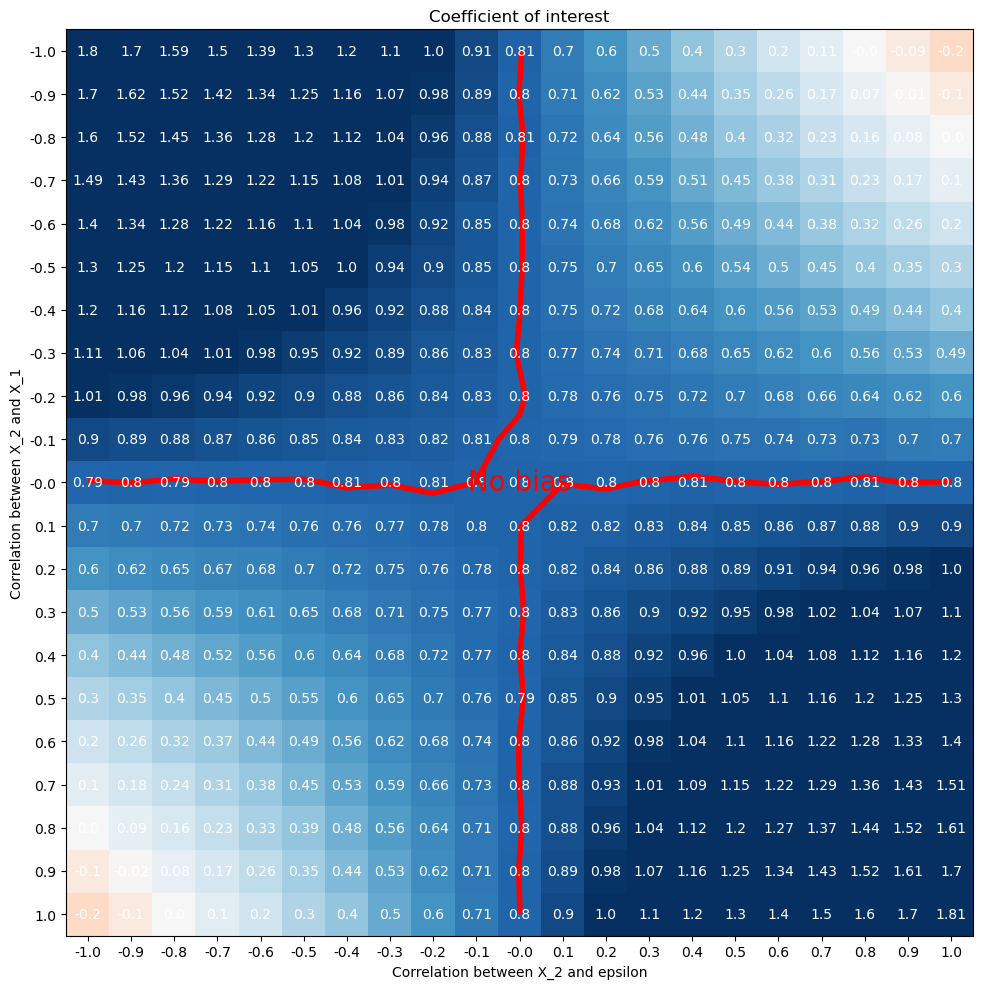

In [5]:
# Plot the results in a heatmap with the correlation between X_2 and epsilon on the x-axis
# and the correlation between X_2 and X_1 on the y-axis. And the coefficient of interest
# on the z-axis. Highlight where the coefficient of interest is equal to 0.8
temp = df_results.pivot(index='corr_X_1_X_2', columns='corr_X_2_epsilon', values='coef')

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(temp, cmap='RdBu', vmin=-1, vmax=1)
# Label x and y ticks from -1 to 1
ax.set_xticks(np.arange(len(corr_X_2_epsilon_grid)))
ax.set_yticks(np.arange(len(corr_X_1_X_2_grid)))
ax.set_xticklabels(np.round(corr_X_2_epsilon_grid, 1))
ax.set_yticklabels(np.round(corr_X_1_X_2_grid, 1))

for i in range(len(corr_X_1_X_2_grid)):
    for j in range(len(corr_X_2_epsilon_grid)):
        text = ax.text(j, i, round(temp.iloc[i, j], 2),
                       ha="center", va="center", color="w")
ax.set_title("Coefficient of interest")

# Label the axes
ax.set_xlabel('Correlation between X_2 and epsilon')
ax.set_ylabel('Correlation between X_2 and X_1')

# Highlight where the z-axis is equal to 0.8
ax.contour(temp, levels=[0.8], colors='red', linewidths=4)
# Label the contour "No bias" at the center of the contour
ax.text(10, 10, 'No bias', ha="center", va="center", color="red", fontsize=20)

fig.tight_layout()


# Save the figure
outfile = repo_f.joinpath('output', 'OLS_simple_OVB.png')
plt.savefig(outfile)

plt.show()



### Proxy of OVB

Investigate how controlling for a proxy impacts estimates.

In [19]:
# Set how correlated the proxy is with the omitted variable
corr_proxy = 0.2
noise = 5
   
# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['corr_X_1_X_2', 'corr_X_2_epsilon', 'coef'])
corr_X_2_epsilon_grid = np.arange(-1, 1.1, 0.1)
corr_X_1_X_2_grid = np.arange(-1, 1.1, 0.1)


for corr_X_1_X_2 in corr_X_1_X_2_grid:
    for corr_X_2_epsilon in corr_X_2_epsilon_grid:

        df = create_OVB_data(corr_X_1_X_2=corr_X_1_X_2, corr_X_2_epsilon=corr_X_2_epsilon)

        # Proxy of omitted variable
        df['proxy'] = corr_proxy*df['X_2'] + np.random.normal(0, noise, 100000)

        # Run OLS regression
        X = df[['X_1', 'proxy']]
        X = sm.add_constant(X)
        Y = df['Y']
        model = sm.OLS(Y, X)
        results = model.fit()

        tmp = pd.DataFrame({'corr_X_1_X_2': corr_X_1_X_2, 'corr_X_2_epsilon': corr_X_2_epsilon, 'coef': results.params['X_1']}, index=[0])
        # Save the coefficient of interest
        df_results = pd.concat([df_results, tmp])
                                                            
    



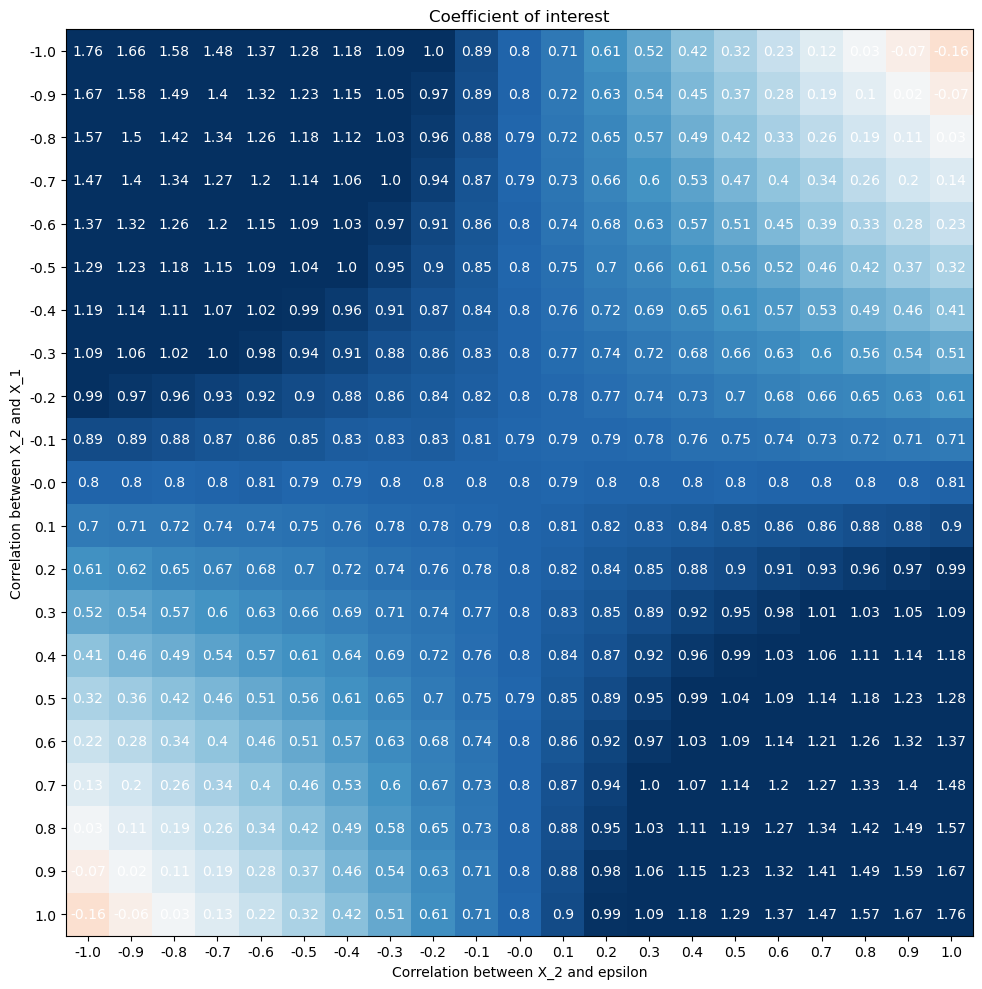

In [20]:
# Plot the results in a heatmap with the correlation between X_2 and epsilon on the x-axis
# and the correlation between X_2 and X_1 on the y-axis. And the coefficient of interest
# on the z-axis. Highlight where the coefficient of interest is equal to 0.8
temp = df_results.pivot(index='corr_X_1_X_2', columns='corr_X_2_epsilon', values='coef')

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(temp, cmap='RdBu', vmin=-1, vmax=1)
# Label x and y ticks from -1 to 1
ax.set_xticks(np.arange(len(corr_X_2_epsilon_grid)))
ax.set_yticks(np.arange(len(corr_X_1_X_2_grid)))
ax.set_xticklabels(np.round(corr_X_2_epsilon_grid, 1))
ax.set_yticklabels(np.round(corr_X_1_X_2_grid, 1))

for i in range(len(corr_X_1_X_2_grid)):
    for j in range(len(corr_X_2_epsilon_grid)):
        text = ax.text(j, i, round(temp.iloc[i, j], 2),
                       ha="center", va="center", color="w")
ax.set_title("Coefficient of interest")

# Label the axes
ax.set_xlabel('Correlation between X_2 and epsilon')
ax.set_ylabel('Correlation between X_2 and X_1')


fig.tight_layout()


# Save the figure
outfile = repo_f.joinpath('output', 'OLS_simple_OVB_proxy.png')
plt.savefig(outfile)

plt.show()



## Selection Bias

In [21]:
def create_selection_bias_data(coef_interest=0.8, epsilon_1_and_2=0.5):

    # Create a dataframe 

    # Main independent variable
    df = pd.DataFrame(np.random.normal(0, 1, 100000).reshape(100000, 1), columns=['epsilon_2'])

    df['X_2'] = np.random.normal(0, 2, 100000) + df['epsilon_2']

    # Treatment variable that is 1 if latent variable is greater than 0
    df['treatment'] = np.where(df['X_2'] > 0, 1, 0)

    # Error term
    df['epsilon_1'] = epsilon_1_and_2*df['epsilon_2']

    # Dependent variable
    df['Y'] = coef_interest*df['treatment'] + 5 + df['epsilon_1']
    

    return df


In [22]:
# Run OLS regression over grid of values of the correlation between epsilon_1 and epsilon_2 
# and save the coefficient in a dataframe.

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['epsilon_1_and_2', 'coef'])
epsilon_1_and_2_grid = np.arange(-5, 5.1, 0.1)

for epsilon_1_and_2 in epsilon_1_and_2_grid:
    
        df = create_selection_bias_data(epsilon_1_and_2=epsilon_1_and_2)
    
        # Run OLS regression
        X = df[['treatment']]
        X = sm.add_constant(X)
        Y = df['Y']
        model = sm.OLS(Y, X)
        results = model.fit()
    
        tmp = pd.DataFrame({'epsilon_1_and_2': epsilon_1_and_2, 'coef': results.params['treatment']}, index=[0])
        # Save the coefficient of interest
        df_results = pd.concat([df_results, tmp])
                                                            
    

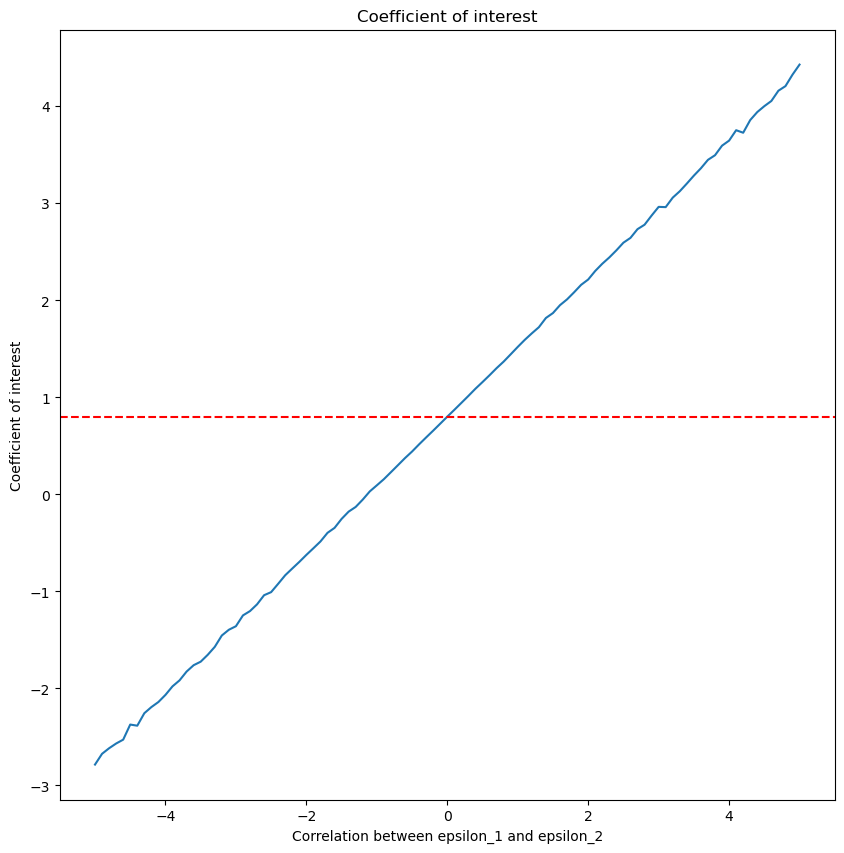

In [23]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(df_results['epsilon_1_and_2'], df_results['coef'])
ax.set_xlabel('Correlation between epsilon_1 and epsilon_2')
ax.set_ylabel('Coefficient of interest')
ax.set_title('Coefficient of interest')
ax.axhline(y=0.8, color='red', linestyle='--')

# Save the figure
outfile = repo_f.joinpath('output', 'OLS_simple_selection_bias.png')
plt.savefig(outfile)

plt.show()
